In [1]:
import collections
import datetime 
import glob
from typing import Optional
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import fluidsynth
import pretty_midi
from IPython import display
import tensorflow as tf

2025-01-07 00:44:48.613960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
sample_rate = 16000

# Downloads the maestro dataset, containing around 1200 midi files.
data_dir = pathlib.Path('data/maestro-v2_extracted/maestro-v2.0.0')
if not data_dir.exists():
    
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

  filenames = glob.glob(str(data_dir/'**/*.midi'))

# At this stage, output should be "Number of files: 1282"

59243107/59243107 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
print(str(data_dir/'**/*.midi'))

data/maestro-v2_extracted/maestro-v2.0.0/**/*.midi


In [7]:
# Practice using pretty_midi to parse a single MIDI file and inspect format of the notes
sample_file = filenames[1000]

pm = pretty_midi.PrettyMIDI(sample_file)

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs = sample_rate)

    waveform_short = waveform[ :seconds * sample_rate]
    return display.Audio(waveform_short, rate = sample_rate)

display_audio(pm)

In [8]:
# Inspecting the instruments used in the file
print("Number of instruments:", len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print("Instrument name:", instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [9]:
# Extract the notes from songs
for i, note in enumerate(instrument.notes[:20]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"{i}: pitch = {note.pitch}, note_name = {note_name},"
          f' duration = {duration:.4f}')
# For the first 10 notes in the song, output is the pitch, note name, and duration of each note
# Pitch is perceptual quality of sound as a MIDI note number

0: pitch = 49, note_name = C#3, duration = 0.6198
1: pitch = 77, note_name = F5, duration = 1.0130
2: pitch = 73, note_name = C#5, duration = 0.3438
3: pitch = 56, note_name = G#3, duration = 0.6341
4: pitch = 56, note_name = G#3, duration = 0.0755
5: pitch = 56, note_name = G#3, duration = 0.0872
6: pitch = 65, note_name = F4, duration = 1.2135
7: pitch = 61, note_name = C#4, duration = 1.2057
8: pitch = 68, note_name = G#4, duration = 1.5430
9: pitch = 56, note_name = G#3, duration = 0.4180
10: pitch = 65, note_name = F4, duration = 0.3151
11: pitch = 61, note_name = C#4, duration = 0.3789
12: pitch = 70, note_name = A#4, duration = 0.9414
13: pitch = 56, note_name = G#3, duration = 0.6380
14: pitch = 56, note_name = G#3, duration = 0.1003
15: pitch = 56, note_name = G#3, duration = 0.1146
16: pitch = 56, note_name = G#3, duration = 0.3984
17: pitch = 58, note_name = A#3, duration = 0.4154
18: pitch = 66, note_name = F#4, duration = 2.0052
19: pitch = 63, note_name = D#4, duration = 

In [10]:
#Extract notes from a MIDI file
def midi_to_notes(midi_file: str):
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    #Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes["pitch"].append(note.pitch)
        notes["start"].append(note.start)
        notes["end"].append(end)
        notes["step"].append(start - prev_start)
        notes["duration"].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [11]:
raw_notes = midi_to_notes(sample_file)
raw_notes

,pitch,start,end,step,duration
0,77,0.976562,1.989583,0.000000,1.013021
1,49,1.006510,1.626302,0.029948,0.619792
2,56,1.636719,2.270833,0.630208,0.634115
3,73,1.916667,2.260417,0.279948,0.343750
4,68,2.140625,3.683594,0.223958,1.542969
...,...,...,...,...,...
1496,61,273.015625,279.102865,0.015625,6.087240
1497,37,273.016927,278.799479,0.001302,5.782552
1498,56,273.022135,279.074219,0.005208,6.052083
1499,38,282.093750,282.264323,9.071615,0.170573


In [12]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
raw_notes_pitch = raw_notes.assign(pitch = sample_note_names)
raw_notes_pitch

,pitch,start,end,step,duration
0,F5,0.976562,1.989583,0.000000,1.013021
1,C#3,1.006510,1.626302,0.029948,0.619792
2,G#3,1.636719,2.270833,0.630208,0.634115
3,C#5,1.916667,2.260417,0.279948,0.343750
4,G#4,2.140625,3.683594,0.223958,1.542969
...,...,...,...,...,...
1496,C#4,273.015625,279.102865,0.015625,6.087240
1497,C#2,273.016927,278.799479,0.001302,5.782552
1498,G#3,273.022135,279.074219,0.005208,6.052083
1499,D2,282.093750,282.264323,9.071615,0.170573


In [13]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="blue", marker="|")
  plt.xlabel('Time (seconds)')
  plt.ylabel('Pitch')
  _ = plt.title(title)

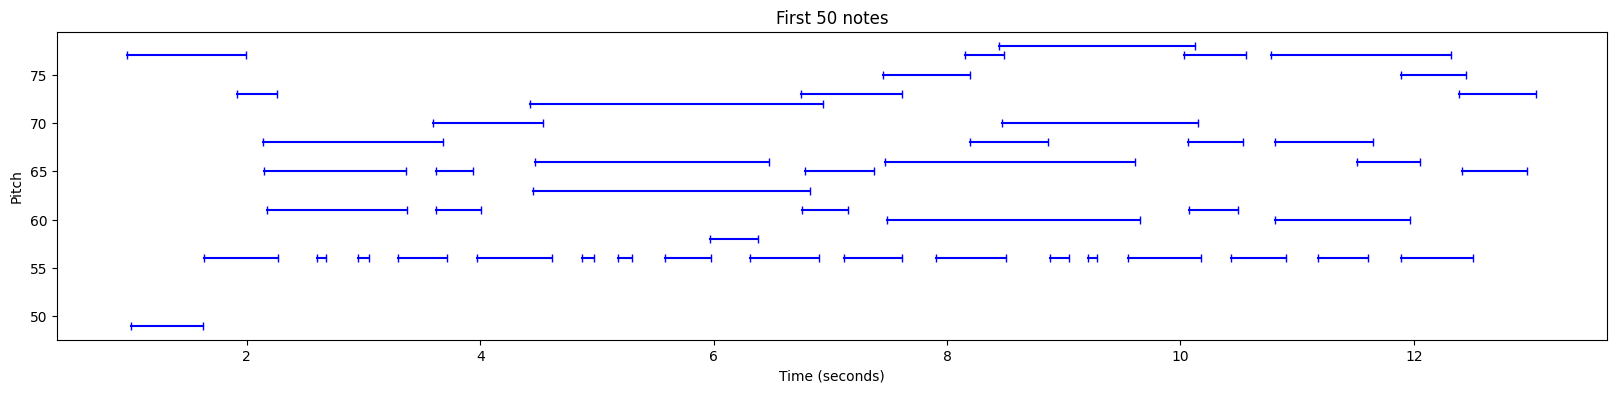

In [14]:
plot_piano_roll(raw_notes, count=50)

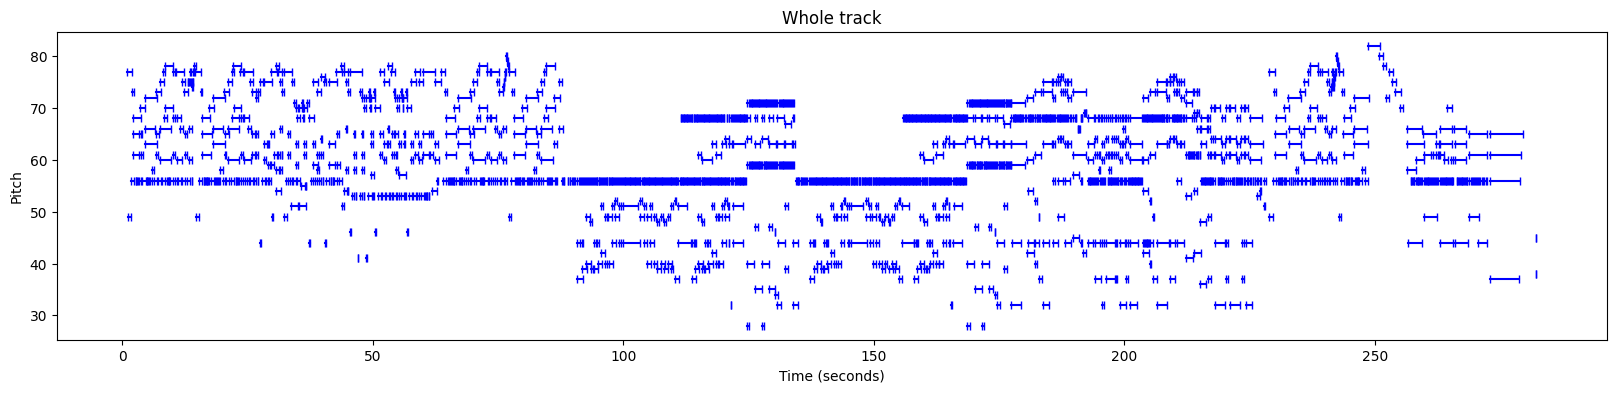

In [15]:
plot_piano_roll(raw_notes)

In [16]:
#check distribution of each note variable
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

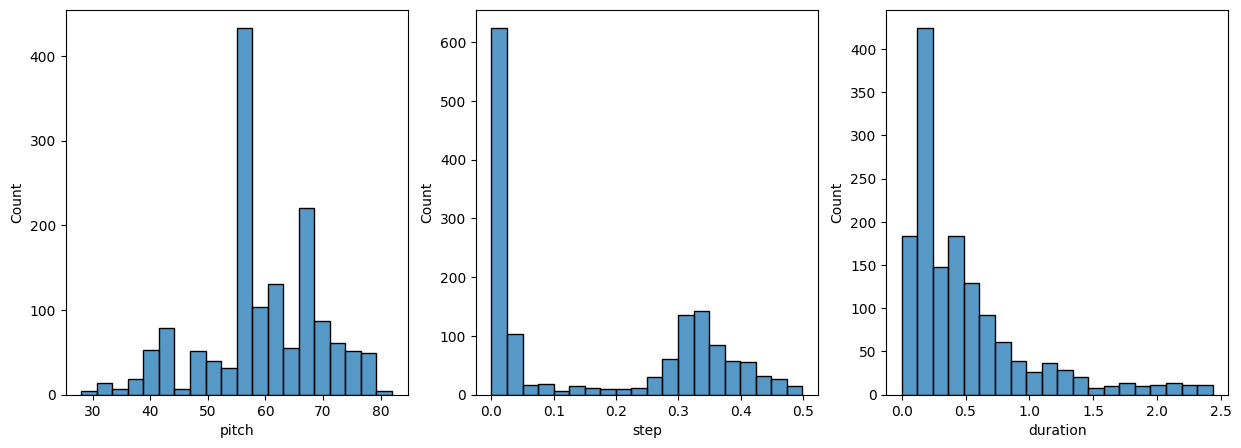

In [17]:
plot_distributions(raw_notes)

In [18]:
#create your own MIDI file
def notes_to_midi(
    notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int=100
    ):

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program = pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note["step"])
        end = float(start + note["duration"])
        note = pretty_midi.Note(
            velocity = velocity, pitch = int(note["pitch"]), start = start, end = end
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm
    

In [19]:
example = "example.midi"
example_pm = notes_to_midi(raw_notes, out_file = example, instrument_name = instrument_name)


In [20]:
#play the generated MIDI file
display_audio(example_pm)

In [21]:
#creating the training dataset
#extract notes from the MIDI files, starting with a small number of files
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [22]:
n_notes = len(all_notes)
print("Number of notes parsed:", n_notes)

Number of notes parsed: 15435


In [23]:
#create a dataset from the parsed notes
key_order = ["pitch", "step", "duration"]
train_notes = np.stack([all_notes[key] for key in key_order], axis = 1)

In [24]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [25]:
#we are training the model on batches of sequences of notes
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  
  seq_length = seq_length + 1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
#setting the sequence length
#vocab size 128 represents all the pitches supported by pretty_midi
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [27]:
#shape of dataset is (100,1) so the model will take 100 notes as input and learn the predict
#the following note as output
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.6015625  0.         0.09244792]
 [0.3828125  0.00390625 0.40234375]
 [0.5703125  0.109375   0.06510417]
 [0.53125    0.09895833 0.06119792]
 [0.5703125  0.10807292 0.05989583]
 [0.4765625  0.06640625 0.05338542]
 [0.6015625  0.01302083 0.0703125 ]
 [0.5703125  0.11979167 0.07682292]
 [0.3984375  0.109375   0.43619792]
 [0.609375   0.00130208 0.09505208]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=54.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.005208333333333037>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.46875>}


2025-01-07 01:13:02.878901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
#batch the examples, configure the dataset
batch_size = 64
buffer_size = n_notes - seq_length  #this is the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [29]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [30]:
#the model will have three outputs, for step, pitch, duration
#custom loss funciton based on eman squared error to encourage the model to output pos. values
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [31]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
#we can see the pitch loss is significantly greater than step and duration
#loss is the total loss computed by summing all other losses
losses = model.evaluate(train_ds, return_dict=True)
losses

240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - duration_loss: 0.1634 - loss: 5.0313 - pitch_loss: 4.8538 - step_loss: 0.0142


2025-01-07 13:12:14.420351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/akalgi/work/default/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.1556001901626587,
 'loss': 5.008670330047607,
 'pitch_loss': 4.8336052894592285,
 'step_loss': 0.019464299082756042}

In [33]:
#use the loss_weights argument to compile
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [34]:
#loss becomes the weighted sum of the individual losses
model.evaluate(train_ds, return_dict = True)

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - duration_loss: 0.1634 - loss: 0.4203 - pitch_loss: 4.8538 - step_loss: 0.0142


2025-01-07 13:50:51.069802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


{'duration_loss': 0.1556001901626587,
 'loss': 0.4167447090148926,
 'pitch_loss': 4.8336052894592285,
 'step_loss': 0.019464299082756042}

In [35]:
#now train the model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [37]:
epochs = 5

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - duration_loss: 0.0438 - loss: 0.2355 - pitch_loss: 3.6095 - step_loss: 0.0113
Epoch 2/5
  9/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - duration_loss: 0.1010 - loss: 0.2922 - pitch_loss: 3.5865 - step_loss: 0.0119

2025-01-07 14:08:17.911003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - duration_loss: 0.0430 - loss: 0.2338 - pitch_loss: 3.5893 - step_loss: 0.0112
Epoch 3/5
  8/240 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - duration_loss: 0.1069 - loss: 0.2975 - pitch_loss: 3.5709 - step_loss: 0.0121

2025-01-07 14:08:21.582871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - duration_loss: 0.0429 - loss: 0.2330 - pitch_loss: 3.5798 - step_loss: 0.0111
Epoch 4/5
  8/240 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - duration_loss: 0.1074 - loss: 0.2984 - pitch_loss: 3.5781 - step_loss: 0.0121

2025-01-07 14:08:25.573404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - duration_loss: 0.0429 - loss: 0.2349 - pitch_loss: 3.5941 - step_loss: 0.0123
Epoch 5/5
  4/240 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - duration_loss: 0.1512 - loss: 0.3438 - pitch_loss: 3.5736 - step_loss: 0.0139

2025-01-07 14:08:29.337215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - duration_loss: 0.0429 - loss: 0.2321 - pitch_loss: 3.5597 - step_loss: 0.0112
Restoring model weights from the end of the best epoch: 5.


2025-01-07 14:08:33.261056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


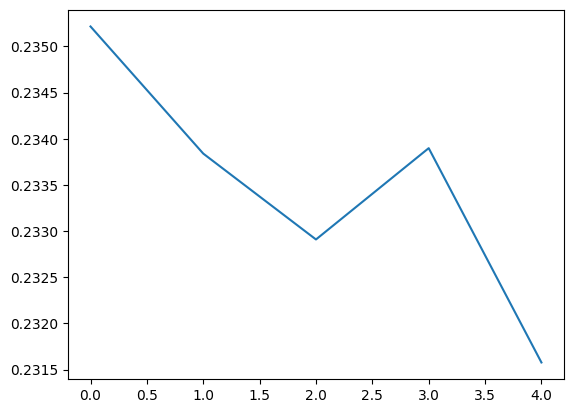

In [38]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [39]:
#now use the model to generate notes
#first need to provide a starting sequence of notes
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:

  assert temperature > 0

  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [40]:
#now generate some notes
temperature = 1.5
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

#pitch is normalized 
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [47]:
sample_notes

array([[7.70000000e+01, 0.00000000e+00, 1.01302083e+00],
       [4.90000000e+01, 2.99479167e-02, 6.19791667e-01],
       [5.60000000e+01, 6.30208333e-01, 6.34114583e-01],
       ...,
       [5.60000000e+01, 5.20833333e-03, 6.05208333e+00],
       [3.80000000e+01, 9.07161458e+00, 1.70572917e-01],
       [4.50000000e+01, 1.70572917e-01, 1.43229167e-02]])

In [48]:
#dataframe of the three variables of each of our generated notes
generated_notes.iloc[:10]

,pitch,step,duration,start,end
0,67,0.180211,0.390485,0.180211,0.570696
1,99,0.427793,0.000000,0.608003,0.608003
2,99,0.422942,0.000000,1.030945,1.030945
3,87,0.414570,0.000000,1.445515,1.445515
4,97,0.411752,0.000000,1.857267,1.857267
5,87,0.409289,0.000000,2.266557,2.266557
6,78,0.408841,0.000000,2.675398,2.675398
7,92,0.409060,0.000000,3.084457,3.084457
8,67,0.408063,0.000000,3.492521,3.492521
9,89,0.410143,0.000000,3.902664,3.902664


In [49]:
# out_file = 'output.mid'
# out_pm = notes_to_midi(
#     generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

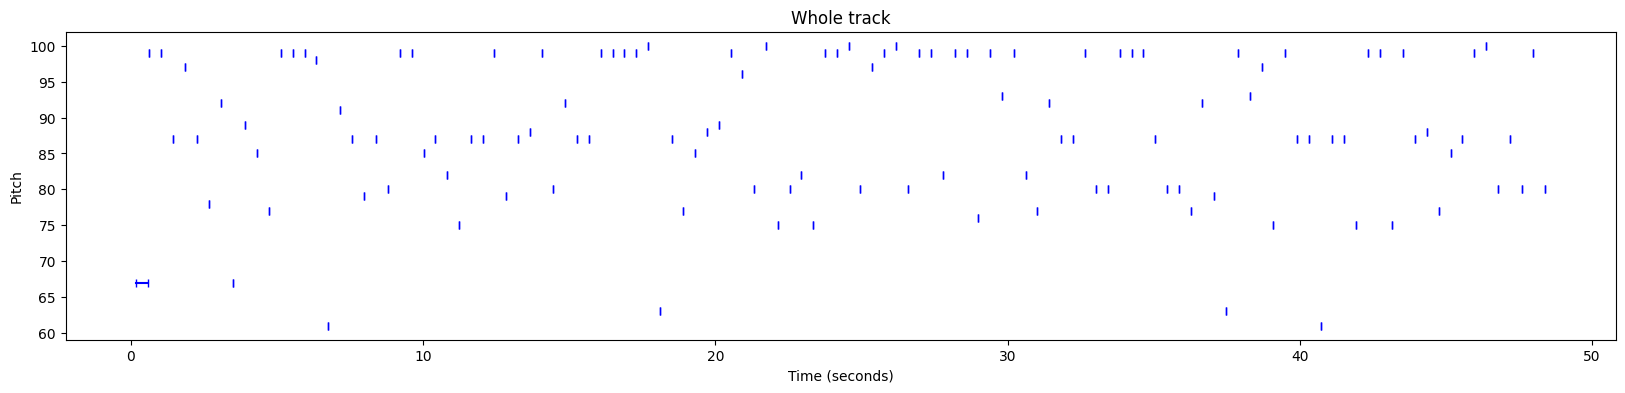

In [43]:
#visualize the generated notes
plot_piano_roll(generated_notes)

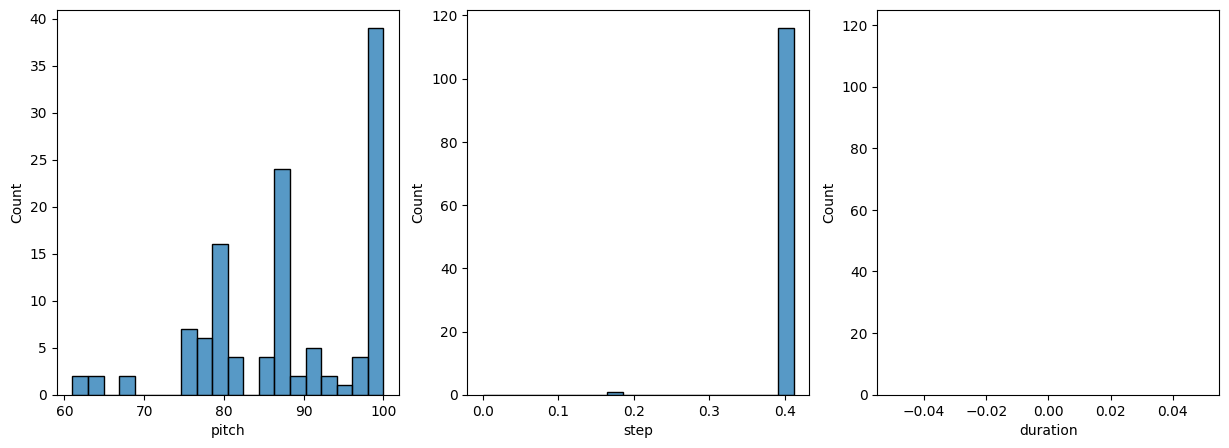

In [44]:
#check the distrubutions of step, pitch, duration
plot_distributions(generated_notes)
#notice the change in distribution of the note variables
#because of the feedback loop between the model's outputs & inputs, it tends to generate
#similar sequences of outputs to minimize the loss
#relevant for step and duration, which use the mean squared loss